## Introduction
This notebook runs all the processing steps one by one for several models and renders the output

## Imports

In [1]:
import sys
import os
import importlib
workspace_path = os.path.abspath(os.path.join(os.path.abspath(''), '..'))
sys.path.append(workspace_path)

from idlmav import MAV, plotly_renderer_context

In [2]:
from typing import Tuple, List, Dict, Set, Union, overload
import torch
from torch import nn, Tensor
import torch.nn.functional as F
import torchvision
import timm

import torchinfo
import torchview

from miniai.init import clean_mem
from miniai.resnet import ResBlock, act_gr, conv

### To reload updated imports

In [3]:
def reload_imports():
    # NB update low-level dependencies before high-level dependencies
    importlib.reload(sys.modules['idlmav_types'])
    importlib.reload(sys.modules['idlmav_utils'])
    importlib.reload(sys.modules['idlmav_tracing'])
    importlib.reload(sys.modules['idlmav_merging'])
    importlib.reload(sys.modules['idlmav_coloring'])
    importlib.reload(sys.modules['idlmav_layout'])
    importlib.reload(sys.modules['idlmav_release_viewer'])
    importlib.reload(sys.modules['idlmav_interactive_viewer'])
    importlib.reload(sys.modules['idlmav'])
    global MAV, plotly_renderer_context
    from idlmav import MAV, plotly_renderer_context

## Models

### Hand-written CNN (for MNIST)
* Found [here](https://github.com/pytorch/examples/blob/main/mnist/main.py)
* Modified for experimental purposes, e.g. breaking the forward pass

In [4]:
class MnistCnn(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

def get_model_cnn_mnist():
    return MnistCnn()

def get_model_cnn_mnist_broken():
    model = MnistCnn()
    model.fc1 = nn.Linear(9216, 120)
    return model

### ResNet18 (from TorchVision)

In [5]:
def get_model_tv_resnet18():
    return torchvision.models.resnet.resnet18()

### ResNet18 (from timm)

In [6]:
def get_model_timm_resnet18():
    return timm.create_model('resnet18', in_chans=3, num_classes=10)

### ResNet (from miniai)

In [7]:
def get_model_miniai_resnet(act=nn.ReLU, nfs=(16,32,64,128,256), norm=nn.BatchNorm2d):
    class GlobalAvgPool(nn.Module):
        def forward(self, x:Tensor): return x.mean((-2,-1))
    layers = [conv(1, 16, ks=5, stride=1, act=act, norm=norm)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]
    layers += [GlobalAvgPool(), nn.Linear(256, 10, bias=False), nn.BatchNorm1d(10)]
    return nn.Sequential(*layers)

### Autoencoder (from miniai)

In [8]:
def get_model_miniai_autoenc(act=act_gr, nfs=(32,64,128,256,512), norm=nn.BatchNorm2d, drop=0.1):
    def up_block(ni, nf, ks=3, act=act_gr, norm=None):
        return nn.Sequential(nn.UpsamplingNearest2d(scale_factor=2),
                            ResBlock(ni, nf, ks=ks, act=act, norm=norm))
    layers = [ResBlock(3, nfs[0], ks=5, stride=1, act=act, norm=norm)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]
    layers += [up_block(nfs[i], nfs[i-1], act=act, norm=norm) for i in range(len(nfs)-1,0,-1)]
    layers += [ResBlock(nfs[0], 3, act=nn.Identity, norm=norm)]
    return nn.Sequential(*layers)

### UNet (from miniai)

In [9]:
def up_block(ni, nf, ks=3, act=act_gr, norm=None):
    return nn.Sequential(nn.UpsamplingNearest2d(scale_factor=2),
                        ResBlock(ni, nf, ks=ks, act=act, norm=norm))

class TinyUnet(nn.Module):
    def __init__(self, act=act_gr, nfs=(32,64,128,256,512), norm=nn.BatchNorm2d):
        super().__init__()
        self.start = ResBlock(3, nfs[0], stride=1, act=act, norm=norm)
        self.dn = nn.ModuleList([ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2)
                                 for i in range(len(nfs)-1)])
        self.up = nn.ModuleList([up_block(nfs[i], nfs[i-1], act=act, norm=norm)
                                 for i in range(len(nfs)-1,0,-1)])
        self.up += [ResBlock(nfs[0], 3, act=act, norm=norm)]
        self.end = ResBlock(3, 3, act=nn.Identity, norm=norm)

    def forward(self, x):
        layers = []
        layers.append(x)
        x = self.start(x)
        for l in self.dn:
            layers.append(x)
            x = l(x)
        n = len(layers)
        for i,l in enumerate(self.up):
            if i!=0: x += layers[n-i]
            x = l(x)
        return self.end(x+layers[0])
    
def get_model_miniai_unet():
    return TinyUnet()

### Model preparation helpers

In [10]:
def get_model_and_input_size(name, device):
    match name:
        case 'cnn_mnist':
            return get_model_cnn_mnist().to(device), (16,1,28,28)
        case 'cnn_mnist_broken':
            return get_model_cnn_mnist_broken().to(device), (16,1,28,28)
        case 'tv_resnet18':
            return get_model_tv_resnet18().to(device), (16,3,160,160)
        case 'timm_resnet18':
            return get_model_timm_resnet18().to(device), (16,3,160,160)
        case 'miniai_resnet':
            return get_model_miniai_resnet().to(device), (16,1,28,28)
        case 'miniai_autoenc':
            return get_model_miniai_autoenc().to(device), (16,3,160,160)
        case 'miniai_unet':
            return get_model_miniai_unet().to(device), (16,3,160,160)
        case _:
            return None
        
def get_models_and_input_tensors(model_names, device):
    """
    This function returns 3 dictionaries, all indexed by the model name:
    * A dictionary of `nn.Module` models
    * A dictionary of tuples: the input sizes for each model
    * A dictionary of tensors that can be passed to each model
    """
    clean_mem()
    models: Dict[str, nn.Module] = {}
    input_sizes: Dict[str, Tuple[int]] = {}
    inputs: Dict[str, Tensor] = {}
    for name in model_names:
        model, input_size = get_model_and_input_size(name, device)
        x = torch.randn(input_size).to(device)
        models[name] = model
        input_sizes[name] = input_size
        inputs[name] = x
    return models, input_sizes, inputs

def remove_all_hooks(model:nn.Module):
    # Iterate through all submodules
    for module in model.modules():
        # Clear forward hooks
        if hasattr(module, '_forward_hooks'):
            module._forward_hooks.clear()

        # Clear backward hooks
        if hasattr(module, '_backward_hooks'):
            module._backward_hooks.clear()

        # Clear pre-forward hooks if any (less common)
        if hasattr(module, '_forward_pre_hooks'):
            module._forward_pre_hooks.clear()


In [11]:
device = 'cpu'  # ['cpu','cuda']
model_names = ['cnn_mnist', 'cnn_mnist_broken', 'tv_resnet18', 'timm_resnet18', 'miniai_resnet', 'miniai_autoenc', 'miniai_unet']
models, input_sizes, inputs = get_models_and_input_tensors(model_names, device)

## Tests

In [12]:
@overload
def run_algorithm(model_name, interactive:bool, 
                  add_overview=True, add_table=True, add_slider=True,
                  merge_threshold=0.01,
                  palette:Union[str, List[str]]='large', 
                  avoid_palette_idxs:Set[int]=set([]), 
                  fixed_color_map:Dict[str,int]={}
                  ): ...

def run_algorithm(model_name, interactive:bool, *args, **kwargs):
    v = MAV(models[model_name], inputs[model_name], device=device, *args, **kwargs)
    if interactive:
        with plotly_renderer_context('notebook_connected'):
            container = v.draw_interactive_graph(*args, **kwargs)
            display(container)
    else:
        with plotly_renderer_context('notebook_connected'):
            fig = v.draw_release_graph(*args, **kwargs)
            fig.show()

def run_comparison(model_name):
    graph = torchview.draw_graph(models[model_name], input_size=input_sizes[model_name])
    graph.fill_visual_graph()
    display(graph.visual_graph)

### Hand-written CNN (for MNIST)

In [13]:
reload_imports()

In [14]:
run_algorithm('cnn_mnist', interactive=False)

In [15]:
reload_imports()

In [16]:
run_algorithm('cnn_mnist', interactive=True)

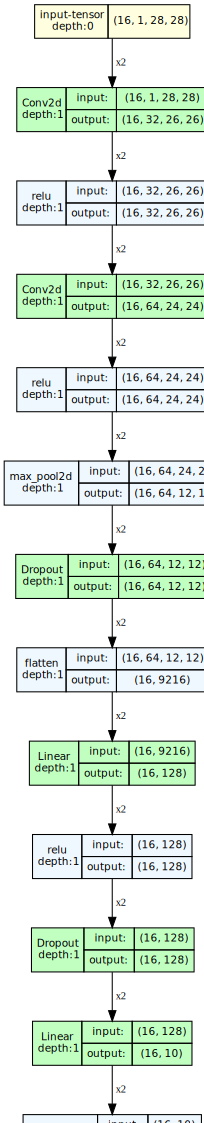

In [17]:
run_comparison('cnn_mnist')

### Broken model

In [18]:
reload_imports()

In [19]:
run_algorithm('cnn_mnist_broken', interactive=False)

/home/dev/ai/idlmav/idlmav_tracing.py:117: UserWarning:

Forward pass failed. Last successful node: "dropout2:Dropout". Possible error node: "fc2:Linear".: mat1 and mat2 shapes cannot be multiplied (16x120 and 128x10)

While executing %fc2 : [num_users=1] = call_module[target=fc2](args = (%dropout2,), kwargs = {})
Original traceback:
None



In [20]:
reload_imports()

In [21]:
run_algorithm('cnn_mnist_broken', interactive=True)

/home/dev/ai/idlmav/idlmav_tracing.py:117: UserWarning:

Forward pass failed. Last successful node: "dropout2:Dropout". Possible error node: "fc2:Linear".: mat1 and mat2 shapes cannot be multiplied (16x120 and 128x10)

While executing %fc2 : [num_users=1] = call_module[target=fc2](args = (%dropout2,), kwargs = {})
Original traceback:
None



In [22]:
try:
    run_comparison('cnn_mnist_broken')
except Exception as e:
    print(f'Comparison failed: {e}')


Comparison failed: Failed to run torchgraph see error message


### ResNet18 (from TorchVision)

In [23]:
reload_imports()

In [24]:
run_algorithm('tv_resnet18', interactive=False)

In [25]:
reload_imports()

In [26]:
run_algorithm('tv_resnet18', interactive=True, add_overview=True, merge_threshold=0.1)

<IPython.core.display.Javascript object>

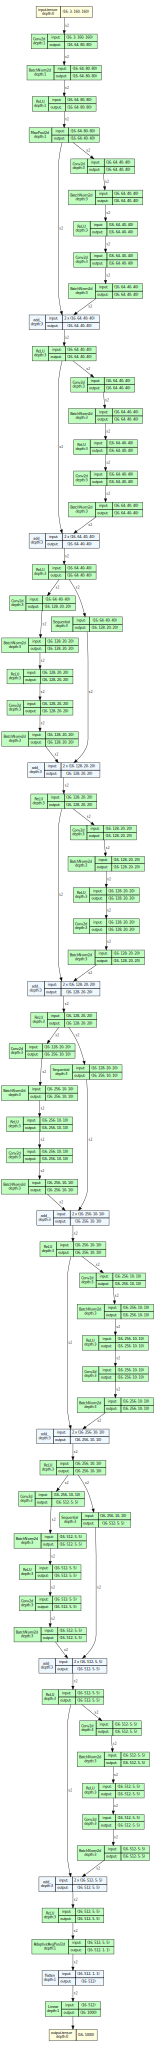

In [27]:
run_comparison('tv_resnet18')

### ResNet18 (from timm)

In [28]:
reload_imports()

In [29]:
run_algorithm('timm_resnet18', interactive=False)

In [30]:
reload_imports()

In [31]:
run_algorithm('timm_resnet18', interactive=True, 
              add_overview=True,
              palette='large', 
              fixed_color_map={}
              )

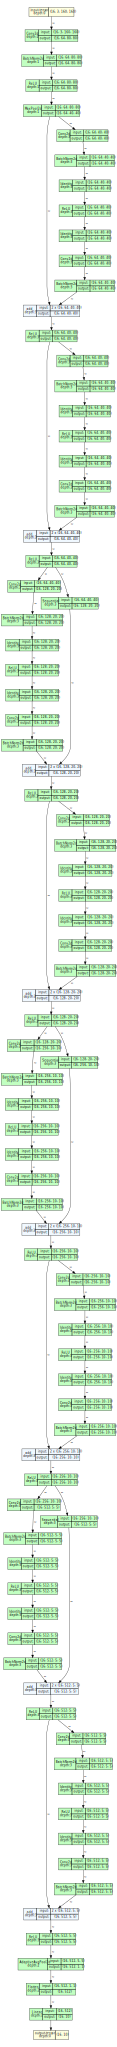

In [32]:
run_comparison('timm_resnet18')

### ResNet (from miniai)

In [33]:
reload_imports()

In [34]:
run_algorithm('miniai_resnet', interactive=False)

In [35]:
reload_imports()

In [36]:
run_algorithm('miniai_resnet', interactive=True, add_overview=True)

In [37]:
# run_comparison('miniai_resnet')

### Autoencoder (from miniai)

In [38]:
reload_imports()

In [39]:
# run_algorithm('miniai_autoenc', interactive=False)

In [40]:
reload_imports()

In [41]:
# run_algorithm('miniai_autoenc', interactive=True)

In [42]:
# run_comparison('miniai_autoenc')

### UNet (from miniai)

In [43]:
reload_imports()

In [44]:
# run_algorithm('miniai_unet', interactive=False)

In [45]:
reload_imports()

In [46]:
# run_algorithm('miniai_unet', interactive=True)